# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Напомним значения столбцов таблицы:

* RowNumber — номер строки таблицы;
* CustomerId — идентификатор клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* Geography — страна проживания клиента (банк межнациональный);
* Gender — пол клиента;
* Age — возраст клиента;
* Tenure — сколько лет клиент пользуется банком;
* Balance — сколько у клиента денег на счетах в банке;
* NumOfProduct — число услуг банка, которыми воспользовался клиент;
* HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
* EstimatedSalary — предполагаемая заработная плата клиента;
* Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

Для начала импортируем библиотеки, которые нам понадобятся:

In [149]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [150]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

### Задание 1

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 


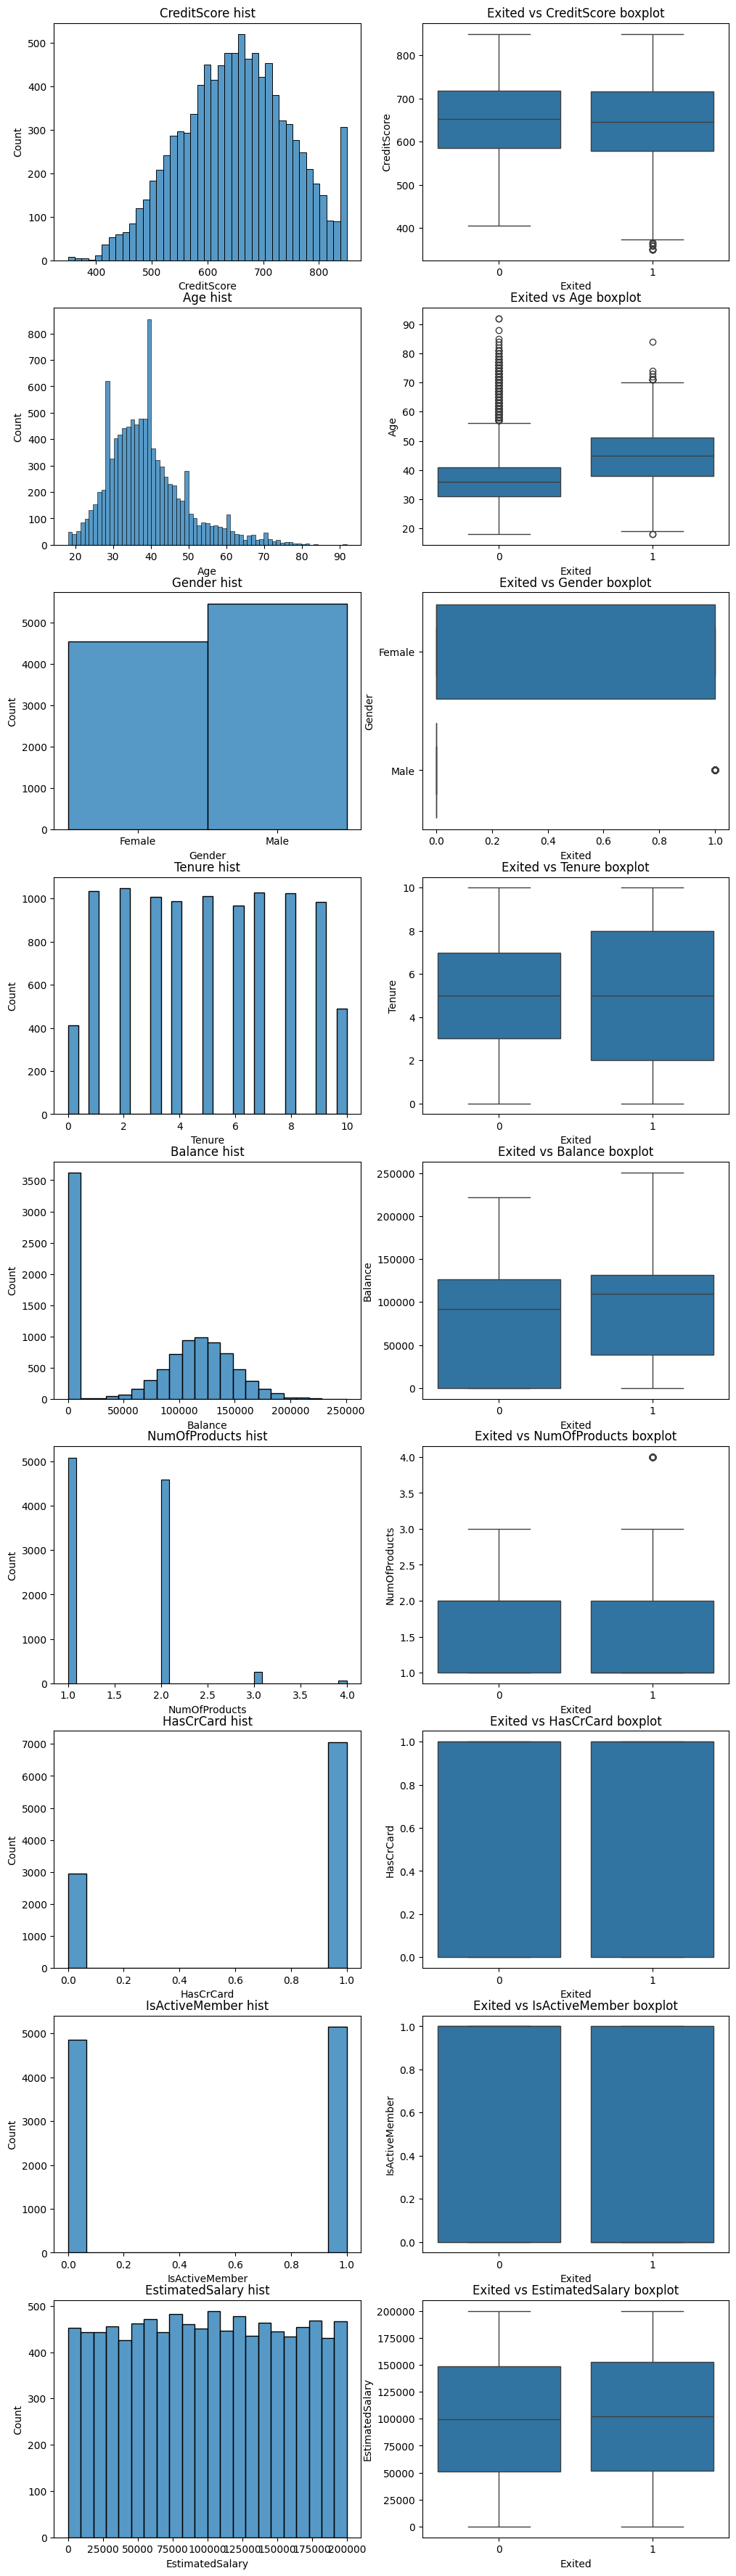

In [151]:
# Построим гистограмму и диаграммный график для каждой важной функции

# создадим список с именами столбцов
features = list(churn_data[['CreditScore', 'Age', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']].columns)

# длина списка будет использоваться для правильного размещения каждой диаграммы на графике
n = len(features)

# инициализируем график
fig, ax = plt.subplots(n, 2, figsize=(12, 45))

# пройдемся по списку объектов и нанесем на график каждый объект.
for i, feature in enumerate(features):
    hist = sns.histplot(data=churn_data, x=churn_data[feature], ax=ax[i][0])
    ax[i][0].set_title('{} hist'.format(feature))
    
    boxplot = sns.boxplot(data=churn_data, x=churn_data['Exited'], y=churn_data[feature], ax=ax[i][1])
    ax[i][1].set_title('Exited vs {} boxplot'.format(feature))
    

<Axes: >

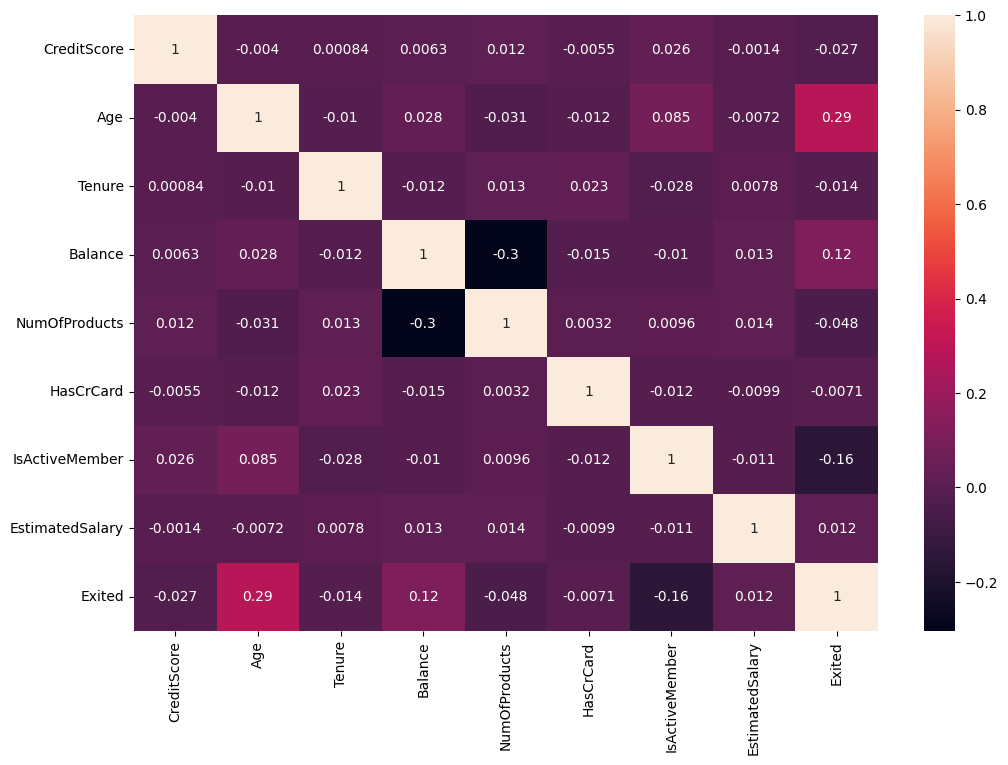

In [152]:
# Построим корреляционную матрицу для числовых признаков

# составим список с названиями столбцов для числовых признаков
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
# инициализируем график
fig= plt.figure(figsize=(12, 8))
# построим корреляционную матрицу
sns.heatmap(churn_data[num_features].corr(), annot=True)

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [153]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [154]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [155]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [156]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 2

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

In [157]:
#BalanceSalaryRatio
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']

#TenureByAge
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']

#CreditScoreGivenAge
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

#1 - Female, 0 - Male
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Female' else 0)

churn_data.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.475488,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,0.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [158]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [159]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [160]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [161]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 3

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

In [162]:
#Standard Scaler
scaler = preprocessing.StandardScaler()

# вычисление минимальных и максимальных параметров для каждого столбца
scaler.fit(X_train)

# нормализация наборов данных X_train и X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 4

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**В данной задаче оптимальной метрикой будет F-мера (или F1-score), поскольку она учитывает как точность (precision), так и полноту (recall) классификации.**

* Точность (Precision): Важно минимизировать количество ложноположительных срабатываний, то есть звонков тем клиентам, которые на самом деле не уйдут. Высокая точность означает, что если модель предсказывает отток, вероятность реального оттока велика.
* Полнота (Recall): В то же время необходимо сохранить как можно больше клиентов, что значит минимизация ложноотрицательных срабатываний — случаев, когда клиенты действительно уйдут, но модель не предсказывает этого. Высокая полнота означает, что большинство клиентов, которые действительно хотят уйти, будут корректно идентифицированы.
* Баланс между Precision и Recall: Поскольку и точность, и полнота важны для задачи, F-мера является логичным выбором, так как она помогает найти баланс между этими двумя метриками. Особенность F1-меры в том, что она наказывает за большие расхождения между precision и recall.

Таким образом, используя F1-меру, вы стремитесь минимизировать как ложноположительные, так и ложноотрицательные срабатывания вашей модели, что соответствует бизнес-целям задачи.

### Задание 5

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

In [163]:
# инициализируем объект класса логистической регрессии
logistic_reg = linear_model.LogisticRegression(random_state=42, max_iter=5000)

# обучим модель
logistic_reg.fit(X_train_scaled, y_train)
# прогнозирование значений X_train_scaled и X_test_scaled
y_train_predict = logistic_reg.predict(X_train_scaled)
y_test_predict = logistic_reg.predict(X_test_scaled)

# Оценим прогноз нашей модели, используя показатель оценки F1
# train data
print('F1 metric for Train data set: ',metrics.f1_score(y_train, y_train_predict))
print('\n')
# test data
print('F1 metric for Test data set: ', metrics.f1_score(y_test, y_test_predict))

F1 metric for Train data set:  0.5121241513094084


F1 metric for Test data set:  0.4942528735632184


Близкие значения F1 для тренировочного и тестового наборов данных свидетельствуют о том, что модель хорошо поддается обобщению и не перестраивается. Однако умеренные значения F1 указывают на то, что есть возможности для улучшения. Были проведены эксперименты с различными значениями параметра C, и никаких существенных улучшений в показателях не наблюдалось. Это может быть связано с тем, что модель уже работает наилучшим образом с учетом текущих функций, или, возможно, из-за других факторов, таких как сложные взаимосвязи, не отраженные моделью, или наличие отклонений в данных. Мы использовали решатель "lbfgs", и применима только регуляризация L2, существенных изменений не наблюдалось. Учитывая потенциальную сложность набора данных, использование полиномиальных функций или других форм функциональной инженерии может помочь улучшить производительность модели

### Задание 6

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

In [164]:
# инициализируем экземпляр класса PolynomialFeatures со степенью=3
# include_bias=False означает, что выходные данные не будут включать столбец для термина intercept (смещение)
poly_features = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

# Подгонка модели полиномиальных объектов к данным X_train_scaled
# На этом этапе вычисляется необходимое количество комбинаций полиномов из предоставленных функций
poly_features.fit(X_train_scaled)

# Преобразуем данные X_train_scaled в их полиномиальное представление функций
# Это создает новые объекты, которые представляют собой полиномиальные комбинации исходных объектов вплоть до 3-й степени
X_train_poly = poly_features.transform(X_train_scaled)

# Аналогично, преобразуем X_test_scaled в его полиномиальное представление объектов.
# Это создает новые функции, которые представляют собой полиномиальную комбинацию исходных функций с точностью до 3-й степени,
# и гарантирует, что тестовые данные расширяются таким же образом, как и обучающие данные
X_test_poly = poly_features.transform(X_test_scaled)



# создаем экземпляр класса логистической регрессии с параметром random_state=42
logistic_poly_reg = linear_model.LogisticRegression(random_state=42, max_iter=10000, C=0.05, penalty='l2')

# Сопоставьте логистическую регрессию на основе X_train_polydata с полиномиальными характеристиками 
# и правильными ответами на основе данных y_train
logistic_poly_reg.fit(X_train_poly, y_train)

# Предсказать класс для X_train_poly и X_test_poly
y_train_poly_predict = logistic_poly_reg.predict(X_train_poly)
y_test_poly_predict = logistic_poly_reg.predict(X_test_poly)

# Давайте оценим прогноз нашей модели с помощью показателя F1 score
# train data
print('F1 metric for Train data with Polynomial features: ',metrics.f1_score(y_train, y_train_poly_predict))
print('\n')
# test data
print('F1 metric for Test data with Polynomial features: ', metrics.f1_score(y_test, y_test_poly_predict))

F1 metric for Train data with Polynomial features:  0.7561837455830389


F1 metric for Test data with Polynomial features:  0.6613333333333333


**Вывод:** Внедрение полиномиальных функций улучшило способность модели прогнозировать отток клиентов, о чем свидетельствует увеличение показателя F1 для обучающего набора данных. Изменение параметра C на 0,05, что меньше значения по умолчанию, равного 1, привело к более строгому ограничению регуляризации модели. Это изменение, по-видимому, способствовало лучшему согласованию тренировочных данных и достойному обобщению тестовых данных, поскольку оценка F1 для тестового набора данных также показала улучшение, хотя и ниже, чем оценка для обучения, что указывает на некоторую переобучаемость.

Вывод, который мы можем сделать, заключается в том, что включение полиномиальных признаков позволило модели логистической регрессии зафиксировать более сложные взаимосвязи в данных, что было невозможно при использовании только линейных признаков. Кроме того, настройка силы регуляризации путем уменьшения значения C, вероятно, помогла модели достичь баланса между подгонкой обучающих данных и сохранением способности обобщать новые, невидимые данные. Стоит отметить, что, хотя более строгая регуляризация помогла в этом сценарии, существует компромисс между предвзятостью и дисперсией, которым необходимо тщательно управлять. Чрезмерная регуляризация может привести к недостаточной подгонке, когда модель слишком проста, чтобы отразить основные тенденции.

Таким образом, интеграция полиномиальных функций и настройка параметра C оказались полезными для прогнозирования производительности модели в этом случае

### Задание 7


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


The threshold value that give highest F1 score for Test data:  0.3500000000000001
F1 metric for Train data with Polynomial features:  0.7566742944317315
F1 metric for Test data with Polynomial features:  0.672686230248307


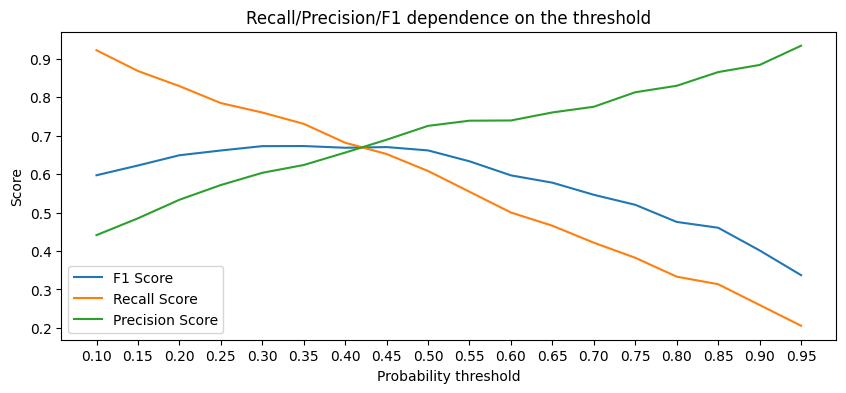

In [165]:
# Составим прогноза вероятности оттока для каждого клиента в тестовой выборке
y_test_proba_pred = pd.Series(logistic_poly_reg.predict_proba(X_test_poly)[:, 1])

# Инициализируем списки, в которых мы будем хранить значения метрик
f1_scores = []
recall_scores = []
precision_scores = []


# Определяем пороговые значения вероятности
thresholds = np.arange(0.1, 1, 0.05)
# Повторяем значения пороговых значений вероятности в цикле
for threshold in thresholds:
    # Делаем прогнозы на основе текущего порогового значения
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Вычисляем F1 Score
    f1_score = metrics.f1_score(y_test, y_test_pred_poly)
    # Вычисляем Recall Score
    recall_score = metrics.recall_score(y_test, y_test_pred_poly)
    # Вычисляем Precision Score
    precision_score = metrics.precision_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    f1_scores.append(f1_score)
    recall_scores.append(recall_score)
    precision_scores.append(precision_score)
   
    
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(thresholds, f1_scores, label='F1 Score')
ax.plot(thresholds, recall_scores, label='Recall Score')
ax.plot(thresholds, precision_scores, label='Precision Score')

ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')

ax.set_xticks(thresholds) 
ax.legend();

# индекс наибольшего значения в списке f1_score
index_of_max_f1 = f1_scores.index(max(f1_scores))
# пороговое значение, дающее наивысшее значение показателя F1 score
best_threshold = list(thresholds)[index_of_max_f1]
print('The threshold value that give highest F1 score for Test data: ', best_threshold)
#----------------Запущенная модель с пороговым значением, равным best_threshold----------------------#
y_train_proba_predict = pd.Series(logistic_poly_reg.predict_proba(X_train_poly)[:, 1])
y_test_proba_predict = pd.Series(logistic_poly_reg.predict_proba(X_test_poly)[:, 1])

y_train_predict = y_train_proba_predict.apply(lambda x: 1 if x > best_threshold else 0)
y_test_predict = y_test_proba_predict.apply(lambda x: 1 if x > best_threshold else 0)


# Оценим прогноз нашей модели с помощью показателя F1 score
# train data
print('F1 metric for Train data with Polynomial features: ',metrics.f1_score(y_train, y_train_predict))
# test data
print('F1 metric for Test data with Polynomial features: ', metrics.f1_score(y_test, y_test_predict))

### Выводы
В заключение, анализ был проведен с использованием модели логистической регрессии с полиномиальными характеристиками для прогнозирования оттока клиентов. Эффективность модели была оценена при различных пороговых значениях вероятности в диапазоне от 0,1 до 0,95 с шагом 0,05, чтобы найти наилучший компромисс между точностью и отзывчивостью при принятии решений о классификации.

Основываясь на построенных оценочных показателях (балл F1, балл запоминания, балл точности) при различных пороговых значениях, можно заметить, что балл F1 максимизируется при пороговом значении, равном приблизительно 0,35. При этом пороговом значении показатель F1 достигает своего пика, представляя собой наилучшее среднее гармоническое значение точности и отзывчивости, полученное моделью.

Выбранный порог в 0,35 указывает на то, что клиенты с прогнозируемой вероятностью оттока выше 0,35 классифицируются как склонные к оттоку, что позволяет более точно выявлять потенциальные случаи оттока. Это может быть особенно полезно, учитывая ограниченность ресурсов и цель эффективного выявления и удержания клиентов, подверженных риску оттока.

Важно отметить, что настройка гиперпараметра, в частности, настройка параметра C, была проведена для контроля силы регуляризации, что оптимизировало производительность модели. Были изучены различные значения C, при этом C=0,05 дало наиболее удовлетворительные результаты с точки зрения оценки F1.

В дальнейшем, возможно, будет полезно изучить дополнительные методы разработки функций и обработки отклонений, чтобы еще больше повысить производительность модели.

Подводя итог, можно сказать, что модель с полиномиальными характеристиками и тщательно подобранными пороговыми значениями и параметрами регуляризации обеспечивает продуманный подход к выявлению потенциальных клиентов, способствуя эффективному распределению ресурсов для удержания клиентов.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [166]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [167]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


In [168]:
# инициализируем экземпляр класса DTC с критерием 'entropy'
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

# Сопоставим модель дерева принятия решений с данными X_train и_train_train
dt.fit(X_train, y_train)

# сделаем предсказадние для X_train и X_test
y_train_predict = dt.predict(X_train)
y_test_predict = dt.predict(X_test)

# оценим прогнозы с помощью оценки F1
# Train data
print('The F1 metric score for Train data: {}'.format(metrics.f1_score(y_train, y_train_predict)))
# Test data
print('The F1 metric score for Test data: {}'.format(metrics.f1_score(y_test, y_test_predict)))

The F1 metric score for Train data: 1.0
The F1 metric score for Test data: 0.56


Модель демонстрирует явные признаки переобучения, поскольку она отлично работает на тренировочных данных с оценкой F1 1,0, но значительно хуже на тестовых данных с оценкой F1 0,56. Это несоответствие в производительности связано с тем, что дерево решений является чрезмерно сложным, поскольку параметры max_depth и min_samples_leaf не были заданы, что позволяет модели расти без ограничений. В результате дерево принятия решений, вероятно, выучило обучающие данные наизусть, приспосабливаясь к выбросам, вместо того чтобы изучать лежащие в его основе закономерности. Это привело к созданию модели, которая не поддается обобщению на новые, невидимые данные, о чем свидетельствует более низкий балл F1 в тестовом наборе. Чтобы улучшить модель, мы могли бы рассмотреть возможность добавления ограничений, таких как установка максимальной глубины или минимального значения выборки, чтобы модель не слишком точно соответствовала обучающим данным.

### Задание 9

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


In [169]:
# Инициализируем экземпляр класса DTC с критерием "entropy",
# максимальной глубиной дерева равной 8, 
# и минимальным количеством выборок на лист, равным 10
dt_controlled = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42, 
    max_depth=8, 
    min_samples_leaf=10
    )

# Сопоставим модель дерева принятия решений с данными X_train и_train_train
dt_controlled.fit(X_train, y_train)

# сделаем предсказадние для X_train и X_test
y_train_predict = dt_controlled.predict(X_train)
y_test_predict = dt_controlled.predict(X_test)

# оценим прогнозы с помощью оценки F1
# Train data
print('The F1 metric score for Train data: {}'.format(metrics.f1_score(y_train, y_train_predict)))
# Test data
print('The F1 metric score for Test data: {}'.format(metrics.f1_score(y_test, y_test_predict)))

The F1 metric score for Train data: 0.7172538392050587
The F1 metric score for Test data: 0.6397849462365591


В этой итерации, благодаря ограничению классификатора дерева принятия решений (DTC) с использованием таких параметров, как максимальная глубина дерева и минимальное количество выборок на лист, была уменьшена тенденция модели к переобучению. Такие параметры, как max_depth=8 и min_samples_leaf=10, предотвращают чрезмерную сложность дерева, помогая ему лучше обобщать невидимые данные.

Полученные в результате оценки F1 демонстрируют эффективность этих ограничений. Модель достигает оценки F1, равной приблизительно 0,717 по данным обучения и 0,640 по данным тестирования. Меньший разрыв между этими показателями по сравнению с предыдущей итерацией указывает на снижение уровня переобучения.

Эти оценки свидетельствуют о том, что модель, хотя и по-прежнему немного перегружена, теперь лучше улавливает лежащие в основе данных закономерности, не слишком точно приспосабливаясь к шуму или выбросам, присутствующим в обучающем наборе. Улучшенный результат теста F1 еще раз подтверждает, что способность нашей модели к обобщению была повышена за счет контроля ее сложности.

### Задание 10

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


In [170]:
# Инициализируем экземпляр класса RandomForestClassifier
# и задаем максимальное количество деревьев равным n_estimators=500, максимальную глубину дерева - max_depth=8, критерий - criterion='энтропия'
# и минимальное количество образцов на лист = min_samples_leaf=10
rf_cf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=8, criterion='entropy', min_samples_leaf=10, random_state=42)

# Random Forest Classifier в X_train, y_train
rf_cf.fit(X_train, y_train)

# Делаем предсказание
y_train_predict = rf_cf.predict(X_train)
y_test_predict = rf_cf.predict(X_test)

# оцениваем модели с помощью показателя F1
print('The F1 score for Train data using RandomForestClassifier model: {}'.format(metrics.f1_score(y_train, y_train_predict)))
print('The F1 score for Test data using RandomForestClassifier model: {}'.format(metrics.f1_score(y_test, y_test_predict)))

The F1 score for Train data using RandomForestClassifier model: 0.7350746268656716
The F1 score for Test data using RandomForestClassifier model: 0.6556473829201102


Использование модели Random Forest Classifier (RFC) позволило повысить эффективность прогнозирования, получив более высокие оценки F1 как для обучающих, так и для тестовых наборов данных по сравнению с моделью классификатора дерева решений (DTC). Модель RFC получила оценку F1, равную приблизительно 0,735 по данным обучения и 0,656 по данным тестирования.

Примечательным наблюдением является меньшая степень переобучения в модели RFC по сравнению с моделью DTC. Это видно из меньшего расхождения между оценками F1 в тренировочных и тестовых наборах данных, что делает модель RFC более универсальной для новых, невидимых данных.

Повышенная производительность модели RFC может быть объяснена ее совокупной природой. RFC, в отличие от DTC, создает несколько деревьев решений во время обучения, каждое из которых строится на основе загруженной выборки данных (выборки выбираются случайным образом с заменой). Для прогнозирования модель RFC учитывает выходные данные всех отдельных деревьев, выбирая подход, основанный на голосовании большинством голосов. Этот комплексный метод по своей сути обеспечивает надежность и разнообразие, что приводит к повышению точности и уменьшению переобучения.

В заключение следует отметить, что классификатор случайных лесов с его комплексным подходом продемонстрировал превосходную производительность с точки зрения оценки F1 и надежности по сравнению с классификатором с одним деревом решений при прогнозировании оттока клиентов.

### Задание 11

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test: 0.68
Train: 0.74


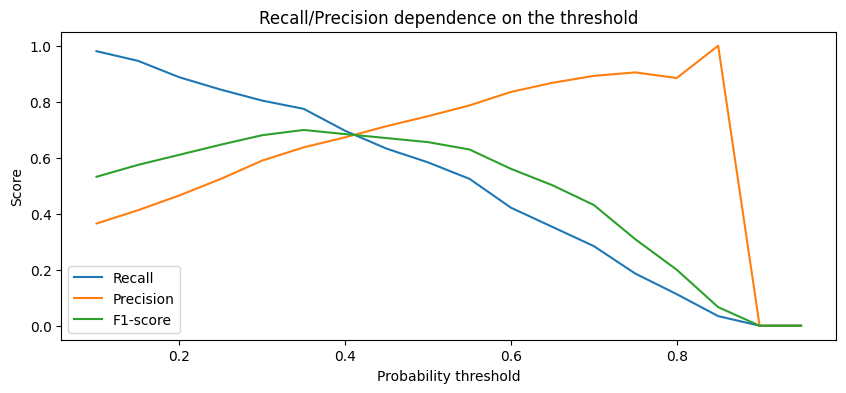

In [171]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf_cf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
#Людей, у которых вероятность зарабатывать >50K больше 0.4 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
# print(metrics.classification_report(y_test, y_test_pred_opt))
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))


Путем перебора различных пороговых значений вероятности был найден оптимальный порог, позволяющий максимизировать оценку F1 модели как в обучающем, так и в тестовом наборах данных. Этот итеративный процесс играет важную роль в точной настройке производительности модели, поскольку он позволяет корректировать границы принятия классификационных решений, гарантируя, что прогнозы модели будут максимально точно соответствовать фактическим результатам.

В этом случае порог вероятности, равный 0,4, был определен как оптимальный, что дало наивысшие оценки F1 для обоих наборов данных — приблизительно 0,74 для обучающих данных и 0,68 для тестовых данных. Это подчеркивает важность выбора соответствующего порогового значения для повышения точности прогнозирования модели, демонстрируя ценность такого подхода для оптимизации модели.

### Задание 12

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

In [172]:
vasiliy_df = pd.DataFrame(
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# давайте преобразуем столбец "Пол" из категориального в числовой
# В наших предыдущих данных мы использовали 1 - для женщин и 0 - для мужчин
vasiliy_df['Gender'] = 0

# Наша модель была разработана на основе данных, которые содержали дополнительные функции "Balance Salary Ratio",
# "Tenure By Age", "Credit Score Given Age"
# Давайте добавим эти функции в наш vasiliy_df
# создадим новый признак Balance Salary Ratio
vasiliy_df['BalanceSalaryRatio'] = vasiliy_df['Balance'] / vasiliy_df['EstimatedSalary']

# создадим новый признак TenureByAge
vasiliy_df['TenureByAge'] = vasiliy_df['Tenure'] / vasiliy_df['Age']

# создадим новый признак CreditScoreGivenAge
vasiliy_df['CreditScoreGivenAge'] = vasiliy_df['CreditScore'] / vasiliy_df['Age']

print('Какова вероятность, что Василий откажется от услуг банка?: {}%'.format(round(rf_cf.predict_proba(vasiliy_df)[:, 1][0] * 100, 2)))

Какова вероятность, что Василий откажется от услуг банка?: 62.29%


### Вывод:

В результате проведённого анализа мы нашли оптимальное значение порога вероятности, при котором метрика F1-score достигает максимального значения на тестовой выборке. Это позволяет нам утверждать, что выбранная модель, использующая данный порог, демонстрирует лучший баланс между precision и recall. Таким образом, мы можем рекомендовать применение этой модели и данного порога в производственной среде, если важен именно баланс точности и полноты предсказаний.